In [181]:
import pandas as pd
import gower
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

In [182]:
df = pd.DataFrame(pd.read_excel('/content/habr_general (2).xlsx'))
df

,Unnamed: 0,Дата размещения,Вакансия,Стаж,Зарплата от,Зарплата до,Город,Дата сбора данных,Число сотрудников,Тип занятости,Можно удаленно
0,0,2024-06-27 16:50:48,Архитектор программного обеспечения,Старший (Senior),388888.888889,500000.000000,Москва,2024-07-01 23:06:03,0,Полный рабочий день,Нет
1,2,2024-06-04 16:24:59,Менеджер проекта,Стажёр (Intern),5000.000000,25000.000000,"Москва, Санкт-Петербург, Казань",2024-07-01 23:06:04,1,Полный рабочий день,Да
2,3,2024-07-01 12:09:30,Бэкенд разработчик,Средний (Middle),210000.000000,270000.000000,Удаленно,2024-07-01 23:06:04,0,Полный рабочий день,Да
3,8,2024-06-04 09:23:18,Менеджер по найму,Стажёр (Intern),77777.777778,100000.000000,Удаленно,2024-07-01 23:06:06,0,Полный рабочий день,Да
4,18,2024-06-06 13:34:21,Менеджер технической поддержки,Средний (Middle),60000.000000,77142.857143,Удаленно,2024-07-01 23:06:10,0,Полный рабочий день,Да
...,...,...,...,...,...,...,...,...,...,...,...
651,3153,2024-07-01 13:29:52,Веб-разработчик,Средний (Middle),200000.000000,257142.857143,Москва,2024-07-01 23:23:36,0,Полный рабочий день,Нет
652,3160,2024-06-03 15:46:09,Фулстек разработчик,Стажёр (Intern),40000.000000,51428.571429,Москва,2024-07-01 23:23:39,1,Неполный рабочий день,Да
653,3176,2024-06-26 13:17:01,DevOps-инженер,Старший (Senior),466666.666667,600000.000000,Удаленно,2024-07-01 23:23:44,0,Полный рабочий день,Да
654,3181,2024-06-27 10:06:33,Фулстек разработчик,Старший (Senior),300000.000000,385714.285714,Екатеринбург,2024-07-01 23:23:45,0,Полный рабочий день,Нет


In [183]:
def eps_selection_graph(data, m=3):
    distances = gower.gower_matrix(data)
    dists_over_pairs = []
    for i in range(distances.shape[0]):
        dists_i = []
        for j in range(distances.shape[0]):
            if (i != j):
                dists_i.append(distances[i][j])
        dists_i = sorted(dists_i)
        dists_over_pairs.append(sum(dists_i[0:m+1])/m)
    plt.plot(sorted(dists_over_pairs))
    plt.xlabel('sorted objects')
    plt.ylabel(f'mean distance over {m} nearest neighbors')

In [184]:
def find_outliers(data, m=3, e=0.1):
    distances = gower.gower_matrix(data)

    db = DBSCAN(eps=e, min_samples=m, metric='precomputed').fit(distances)
    labels = db.labels_
    print('Number of outliers: ', pd.Series(labels).value_counts()[-1])
    return np.where(labels == -1)[0]

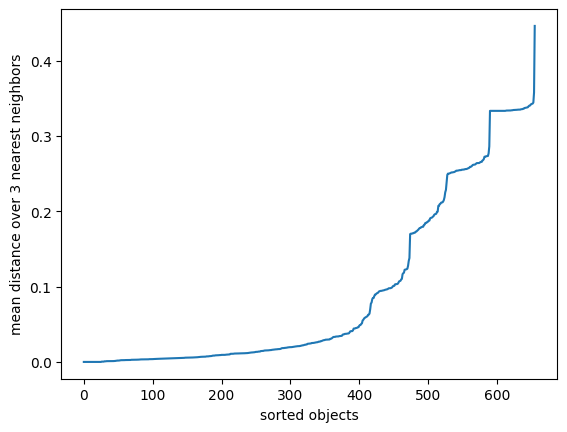

In [185]:
eps_selection_graph(df[['Стаж', 'Вакансия', 'Зарплата от', 'Зарплата до']].values, m=3)

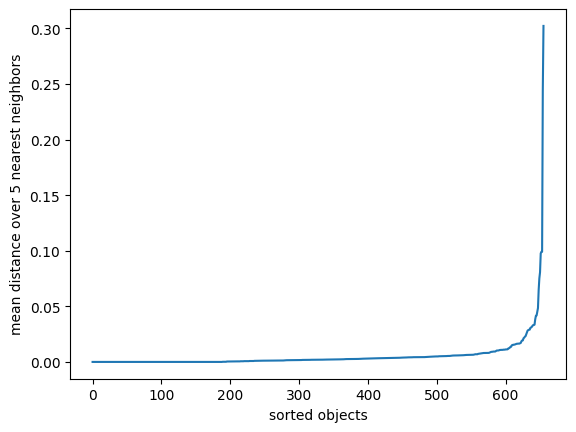

In [186]:
eps_selection_graph(df[['Стаж', 'Зарплата от', 'Зарплата до']].values, m=5)

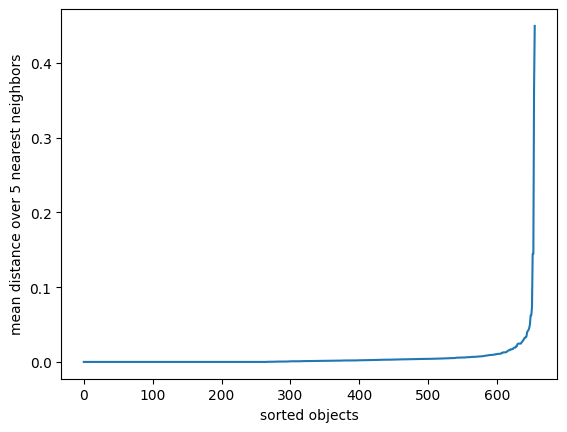

In [187]:
eps_selection_graph(df[['Зарплата от', 'Зарплата до']].values, m=5)

In [188]:
find_outliers(df[['Стаж', 'Вакансия', 'Зарплата от', 'Зарплата до']].values, m=3, e=0.09)

Number of outliers:  127


array([  9,  11,  13,  22,  27,  33,  40,  59,  61,  62,  63,  75,  76,
        78,  84,  85,  86,  87,  92,  95, 108, 113, 114, 117, 119, 126,
       129, 130, 135, 140, 147, 155, 157, 159, 162, 180, 184, 187, 188,
       190, 200, 202, 210, 220, 222, 225, 227, 232, 236, 241, 246, 262,
       264, 267, 270, 271, 289, 299, 305, 307, 313, 314, 317, 321, 324,
       332, 334, 336, 339, 343, 344, 345, 347, 350, 354, 360, 365, 377,
       381, 383, 385, 387, 396, 400, 403, 404, 405, 413, 416, 423, 429,
       435, 436, 437, 459, 465, 467, 476, 480, 483, 502, 503, 511, 517,
       526, 531, 537, 550, 555, 559, 563, 567, 570, 572, 582, 599, 604,
       608, 617, 618, 623, 631, 632, 640, 644, 647, 652])

In [189]:
find_outliers(df[['Стаж', 'Зарплата от', 'Зарплата до']].values, m=5, e=0.05)

Number of outliers:  7


array([ 12,  75, 191, 235, 405, 543, 610])

In [190]:
find_outliers(df[['Зарплата от', 'Зарплата до']].values, m=5, e=0.05)

Number of outliers:  4


array([ 12,  75, 405, 610])

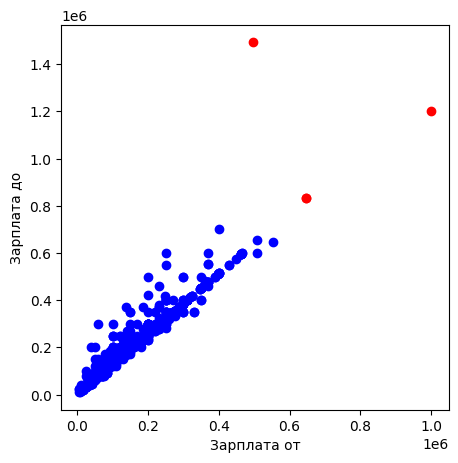

In [191]:
data = df[['Зарплата от', 'Зарплата до']].values
distances = gower.gower_matrix(data)

db = DBSCAN(eps=0.05, min_samples=5, metric='precomputed').fit(distances)
labels = db.labels_

unique_labels = set(labels)
colors = ['blue', 'red']

plt.figure(figsize=(5,5))
for color, label in zip(colors, unique_labels):
    sample_mask = [True if l == label else False for l in labels]
    plt.plot(data[:,0][sample_mask], data[:, 1][sample_mask], 'o', color=color);
plt.xlabel('Зарплата от');
plt.ylabel('Зарплата до');